# Expectation value calculations with Amazon Braket program sets

## 1. Introduction
Amazon Braket's `ProgramSet` feature enables significant reductions in runtime and cost by submitting multiple quantum circuits together. The efficiency gains are even greater when the circuits represent different realizations of a single parametric circuit, which is often the case in variational quantum algorithms.

One prominent example is the Variational Quantum Eigensolver (VQE), a hybrid quantum-classical algorithm used to find ground state energies of molecular systems. VQE relies on repeatedly calculating quantum expectation values of a Hamiltonian for quantum states that evolve during optimization. These calculations form the computational bottleneck of the algorithm, making efficient execution crucial for practical applications.

With Braket's `ProgramSet` feature we can simplify the implementation of these calculations by directly submitting a program set for a given Hamiltonian and requesting its expectation value. However, the default approach of allocating the same number of shots to each observable term in the Hamiltonian, regardless of the magnitude of its coefficient and its contribution to the expectation value, can be detrimental to the accuracy of the final estimation.

### 1.1 Notebook overview
In this notebook, we will demonstrate how to overcome this limitation and achieve better statistical accuracy with the same total number of shots. We will:
1. Set up a random Hamiltonian and quantum state
2. Calculate the exact expectation value as a reference
3. Implement a shot-based approximation using `ProgramSet` with its default (uniform) shot allocation 
4. Develop an improved (weighted) shot allocation strategy and demonstrate how to implement it using a `ProgramSet` instance
5. Compare the results of both approaches

Through this comparison, we'll show how to achieve improved precision by using more circuits while keeping the same total shot budget (and thus the cost of executing our quantum algorithm) fixed.

In [ ]:
import math
import random
from collections.abc import Callable

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, FreeParameter, Observable
from braket.devices import LocalSimulator
from braket.program_sets import CircuitBinding, ProgramSet

In [2]:
# We'll use a local state-vector simulator for the demonstration.
device = LocalSimulator()

## 2. Setup: Hamiltonian, state, and ground truth 
Let's create a random Hamiltonian and initial state. Note that we allow the coefficients of the Hamiltonian to vary (relative to one another) up to three orders of magnitude. This is not uncommon in realistic physical systems where terms can have different energy scales. For reproducibility purposes, we fixed the seed for the pseudo-random numbers affecting our setup. Feel free to change it and test different Hamiltonians and states.

In [3]:
random.seed(42)  # For reproducibility, but feel free to change

def int_to_pauli(number: int) -> str:
    """Convert an integer to base 4, to produce a Pauli string observable."""
    if number == 0:
        return "I"
    
    digits = "IXYZ"
    result = ""
    
    while number > 0:
        remainder = number % 4
        result = digits[remainder] + result
        number //= 4
    
    return result

def generate_random_hamiltonian(num_qubits: int, num_terms: int,
                                max_order: int = 3) -> tuple[list[str], list[float]]:
    """
    Generate a random Hamiltonian with specified number of terms.
    
    Args:
        num_qubits: Number of qubits in the system
        num_terms: Number of Pauli string terms in the Hamiltonian
        max_order: Maximum order of magnitude for coefficients
        
    Returns:
        terms: List of Pauli string terms
        coefficients: List of corresponding coefficients
    """
    terms = []
    for i in random.sample(range(4**num_qubits), num_terms):
        term = int_to_pauli(i)
        terms.append("I"*(num_qubits-len(term)) + term)
    coefficients = [(1 - 2*random.random())*(10 ** random.randint(0,max_order)) for _ in range(num_terms)]
    return terms, coefficients

def create_random_state(num_qubits: int) -> Circuit:
    """
    Create a parameterized quantum circuit with two layers of random (Ry) single-qubit rotations
    and an entanglement layer of two-qubit (Cnot) gates in between.
    
    Args:
        num_qubits: Number of qubits in the circuit
        
    Returns:
        Circuit: A parameterized quantum circuit
    """
    circ = Circuit()

    param_idx = 0
    # First layer of rotations
    for i in range(num_qubits):
        circ.ry(i, FreeParameter(f"parameter_{param_idx}"))
        param_idx += 1

    # Entangling layer
    for i in range(num_qubits - 1):
        circ.cnot(control=i, target=i+1)

    # Second layer of rotations
    for i in range(num_qubits):
        circ.ry(i, FreeParameter(f"parameter_{param_idx}"))
        param_idx += 1

    return circ

In [4]:
# Define our quantum system
num_qubits = 5
num_paulis = 10

# Generate random Hamiltonian
paulis, coeffs = generate_random_hamiltonian(num_qubits, num_paulis)

# Format the Hamiltonian for display
hamiltonian_string = f"{coeffs[0]:.2f}*{paulis[0]} "
for i in range(1, len(coeffs)):
    if i%5 == 0:
        hamiltonian_string += "\n"+" "*len("Hamiltonian: H = ")
    if coeffs[i] >= 0:
        hamiltonian_string += "+"
    hamiltonian_string += f"{coeffs[i]:.2f}*{paulis[i]} "
    
print("Hamiltonian: H = ", hamiltonian_string)

Hamiltonian: H =  9.40*IZYXI +0.53*IIZIZ -122.49*YIZIZ +55.91*XZZXX -0.62*XZIYX 
                 -5.18*XIXZX -39.63*IZXIX +4.44*IYZIY -91.44*ZXYII +795.58*IXIIX 


In [5]:
# Create a parameterized circuit and bind it with random parameters
state_circuit_unbound = create_random_state(num_qubits)

# Generate random parameters
parameters = {}
for param_idx in range(2*num_qubits):
    parameters[f"parameter_{param_idx}"]=np.pi*random.random()

# Bind the parameters to create a concrete circuit
state_circuit = state_circuit_unbound(**parameters)
print(state_circuit)

T  : │     0      │  1  │     2      │     3      │     4      │     5      │
      ┌──────────┐       ┌──────────┐                                        
q0 : ─┤ Ry(0.30) ├───●───┤ Ry(1.68) ├────────────────────────────────────────
      └──────────┘   │   └──────────┘                                        
      ┌──────────┐ ┌─┴─┐              ┌──────────┐                           
q1 : ─┤ Ry(2.66) ├─┤ X ├──────●───────┤ Ry(3.06) ├───────────────────────────
      └──────────┘ └───┘      │       └──────────┘                           
      ┌──────────┐          ┌─┴─┐                  ┌──────────┐              
q2 : ─┤ Ry(1.90) ├──────────┤ X ├──────────●───────┤ Ry(1.19) ├──────────────
      └──────────┘          └───┘          │       └──────────┘              
      ┌──────────┐                       ┌─┴─┐                  ┌──────────┐ 
q3 : ─┤ Ry(2.54) ├───────────────────────┤ X ├──────────●───────┤ Ry(1.73) ├─
      └──────────┘                       └───┘          │       

### Computing the exact expectation value
We first compute the exact expectation value, which will serve as our reference for evaluating the accuracy of our shot-based approximations.

In [6]:
def observable_from_string(s: str) -> Observable:
    """
    Convert a Pauli string to a Braket Observable.
    
    Args:
        s: String representation of a Pauli operator (e.g., "IXYZ")
        
    Returns:
        Observable: Corresponding Braket Observable
    """
    gates = {"I": Observable.I, "X": Observable.X,
             "Y": Observable.Y, "Z": Observable.Z}
    return Observable.TensorProduct([gates[pauli](idx) for idx, pauli in enumerate(s)])

def compute_exact_expectation_value(paulis: list[str], coeffs: list[float], state_circuit: Circuit) -> float:
    """
    Compute the exact expectation value of a Hamiltonian with respect to a quantum state.
    
    Args:
        paulis: List of Pauli string terms
        coeffs: List of corresponding coefficients
        state_circuit: Quantum circuit representing the state
        
    Returns:
        float: Exact expectation value
    """
    device = LocalSimulator()  # Ensure that in the scope of this function device is always a simulator
    e_exact = 0.0
    for c, p in zip(coeffs, paulis):
        circuit = state_circuit.copy()
        circuit.expectation(observable_from_string(p))
        result = device.run(circuit, shots=0).result()
        e_exact += c * result.values[0]
    return e_exact

In [7]:
# Calculate the exact expectation value
exact_expectation_value = compute_exact_expectation_value(paulis, coeffs, state_circuit)
print(f"Exact expectation value: {exact_expectation_value}")

Exact expectation value: 265.50115639868187


## 3. Finite shot approximation with uniform shot allocation
Now we'll approximate the expectation value using a finite number of shots. First, we'll use a `ProgramSet` with its default shot allocation strategy, where each term in the Hamiltonian receives the same number of shots.

In [8]:
# Create a Braket Observable representing the full Hamiltonian
hamiltonian = coeffs[0] * observable_from_string(paulis[0])
for c,p in zip(coeffs[1:], paulis[1:]):
    hamiltonian += c * observable_from_string(p)

In [9]:
# Prepare the parameter list for the circuit binding
parameter_lists = {}
for param_idx in range(2*num_qubits):
    key = f"parameter_{param_idx}"
    parameter_lists[key]=[parameters[key]]
parameter_lists

{'parameter_0': [0.3038434589418326],
 'parameter_1': [2.6624820752759164],
 'parameter_2': [1.896661264923146],
 'parameter_3': [2.535668253823408],
 'parameter_4': [2.292520020168252],
 'parameter_5': [1.6846102327625636],
 'parameter_6': [3.05713333521001],
 'parameter_7': [1.1892008185689509],
 'parameter_8': [1.7342867916910418],
 'parameter_9': [2.6056516000703174]}

### 3.1 Creating a program set
We will create a program set to calculate our expectation value. We can pass the full Hamiltonian as the only observable to the `CircuitBinding` instance initializing our program. Internally, the workflow will create different executables for the different observables (summands) comprising our Hamiltonian (`Sum`).

In [10]:
# Create a CircuitBinding with our parameterized circuit, parameters, and Hamiltonian
binding = CircuitBinding(state_circuit_unbound, [parameters], observables=hamiltonian)

# Create a ProgramSet from the binding
program_set = ProgramSet(binding)

In [11]:
print(f"Total number of executables: {program_set.total_executables}")

Total number of executables: 10


In [12]:
def compute_shot_expectation_value(program_set: ProgramSet, total_shots: int) -> float:
    """
    Compute the expectation value using a finite number of shots.
    
    Args:
        program_set: ProgramSet containing the circuit and observables
        total_shots: Total number of shots to distribute among executables
        
    Returns:
        float: Estimated expectation value
    """
    # The ProgramSetQuantumTask result returned by device.run(...).result() can be queried as result[program_id][executable_id].
    # There is only one program in our set (as we provided one value per free parameter in our circuit and one observable, namely
    # the Sum Hamiltonian). We can ask for the expectation value directly (as we do in the line below) or obtain it manually as:
    # sum([measured_entry.expectation for measured_entry in result[0]])
    return device.run(program_set, shots=total_shots).result()[0].expectation()

Note the simplicity of the implementation - we submitted the program set (created with the full Hamiltonian as the only observable) to the device and obtained the expectation value estimate directly from the returned result. Let's test it using 10,000 shots total.

In [13]:
# Set our shot budget
total_shots = 10000

# Test the uniform expectation value calculation
uniform_result = compute_shot_expectation_value(program_set, total_shots)
print(f"Expectation value estimate (uniform allocation): {uniform_result:.2f}")

Expectation value estimate (uniform allocation): 262.33


### 3.2 Gathering results
We'll keep our estimation shot budget to 10,000 total shots and examine the performance of our `uniform_estimator` in this setting. We run 100 independent evaluations of the estimator to statistically assess its performance and plot a histogram of the results below.

In [14]:
# Set number of trials for our statistical analysis
num_trials = 100

# Create a shorthand for our estimator
def uniform_estimator(total_shots):
    return compute_shot_expectation_value(program_set=program_set, total_shots=total_shots)

In [15]:
def gather_and_plot_statistics(
    estimator: Callable[[int], float], 
    exact_expectation: float, 
    total_shots: int, 
    num_trials: int, 
    color: str = 'blue', 
    label: str | None = None
) -> list[float]:
    """
    Run multiple trials of expectation value estimation and plot the distribution.
    
    Args:
        estimator: Function that estimates the expectation value
        exact_expectation: The exact expectation value for reference
        total_shots: Total number of shots to use per trial
        num_trials: Number of trials to run
        color: Color for the histogram
        label: Label for the histogram in the legend
        
    Returns:
        list: The expectation values from all trials
    """
    # Run multiple trials and collect the results
    values = [estimator(total_shots) for _ in tqdm(range(num_trials))]
    mean = np.mean(values)
    std = np.std(values)
    
    # Create a histogram of the results
    plt.figure(figsize=(10, 6))
    bins = np.arange(np.min(values), np.max(values), (np.max(values)-np.min(values))/20)
    plt.hist(values, color=color, alpha=0.5, bins=bins, label=label if label else color)
    
    # Set the y-axis limit
    y_max = int(np.ceil(plt.ylim()[1]))
    plt.ylim(0, y_max)
    
    # Plot reference line for the exact value
    ev_line_height = (2*y_max//3)
    plt.plot([exact_expectation]*ev_line_height, np.arange(ev_line_height), color="black", label="Exact value")
    
    # Add labels and legend
    plt.xlabel("Expectation Value")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of Expectation Value Estimates (Mean: {mean:.4f}, Std: {std:.4f})")
    plt.legend()
    
    # Print statistics
    print(f"Mean: {mean:.4f}, Standard Deviation: {std:.4f}")
    
    return values

Running uniform allocation of 10000 shots over the 10 circuit realizations: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


100%|██████████| 100/100 [00:30<00:00,  3.32it/s]

Mean: 265.6487, Standard Deviation: 22.1004


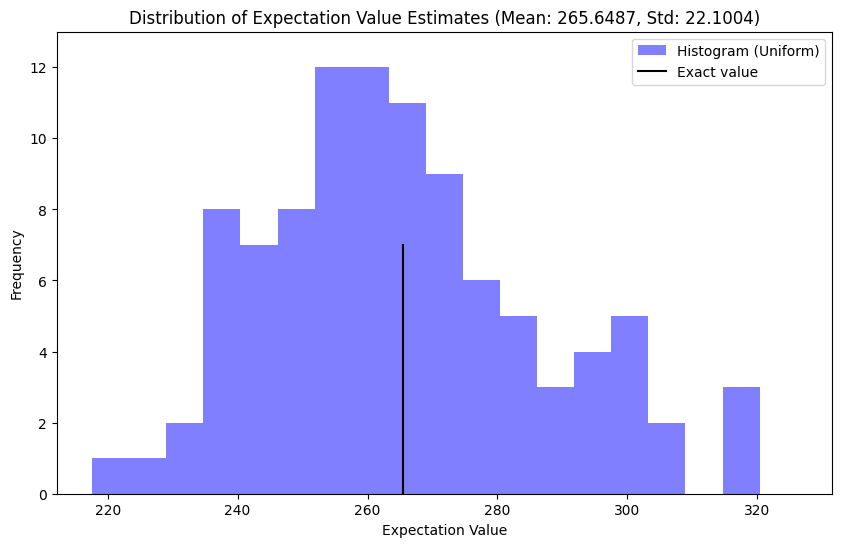

In [16]:
# Calculate the shot allocation for uniform distribution
shot_allocation = [(total_shots//program_set.total_executables) for _ in range(program_set.total_executables)]
print(f"Running uniform allocation of {total_shots} shots over "
      f"the {program_set.total_executables} circuit realizations: {shot_allocation}")

# Run the trials and plot the results
uniform_ev = gather_and_plot_statistics(uniform_estimator, exact_expectation_value, total_shots, num_trials,
                                        color="blue", label="Histogram (Uniform)")

The histogram above reveals that the variance of our estimator is quite large. This high variance stems from allocating the same number of shots to each term in the Hamiltonian, regardless of the magnitude of its coefficient.

## 4. Improved approach: weighted shot allocation
To address this inefficiency, we can develop a more intelligent shot allocation strategy. Notice that the overall variance of our expectation value estimate depends on the variances of measurements for each Pauli string term. The key insight is that terms with larger coefficients generally contribute more to both the expectation value and its uncertainty, so they should receive proportionally more measurement shots.

An efficient shot allocation strategy will distribute shots proportional to the magnitude of each term's coefficient in the Pauli string expansion of our Hamiltonian. This approach reduces the overall variance of the estimator for a fixed total shot budget.

The function below constructs such allocation: given an array of target weights $[w_1, \cdots, w_m]$, and a required total number of shots $N$, it will return a shot allocation array $[n_1, \cdots, n_m]$, such that $\sum_i n_i=N$ and $\frac{w_1}{n_1}\approx\cdots\approx\frac{w_m}{n_m}$. It does so by greedily allocating shots, such that the maximum of the ratios $\frac{w_i}{n_i}$ (which in an ideal allocation should be constant for all $i$) is decreased at each step.

In [17]:
def allocate_by_weight(
    target_weights: list[int | float], 
    total_allocation: int, 
    min_allocation: int = 1
) -> list[int]:
    """
    Allocate items by weight with minimum allocation constraints.
    
    Args:
        target_weights: List of target weights
        total_allocation: Total number of items to allocate
        min_allocation: Minimum allocation per bin
        
    Returns:
        List of allocated counts per bin. 
        Each bin's relative weight aims to approximate the provided target weight.
    """
    # Validate the inputs
    size = len(target_weights)
    
    assert (min_allocation*size <= total_allocation), \
         f"Can't allocate {total_allocation} items across {size} bins with at least {min_allocation} items per bin"

    # Secure the required minimum allocation first
    allocation = [min_allocation] * size

    # In an ideal allocation abs(target_weights[i]) / allocation[i] will be constant (for all i)
    # So when we allocate our leftover budget, at each step we simply decrease the current maximum
    # value of the ratio above
    for i in range(total_allocation - min_allocation*size):
        idx = max(range(size), key = lambda j: abs(target_weights[j]) / (max(allocation[j],1)))
        allocation[idx] += 1

    return allocation

In [18]:
# Calculate the optimal shot allocation based on coefficient magnitudes
best_allocation = allocate_by_weight(coeffs, total_shots, 0)
print(f"Best allocation of {total_shots} shots over the {program_set.total_executables} different circuits: {best_allocation}")

Best allocation of 10000 shots over the 10 different circuits: [84, 5, 1089, 497, 6, 46, 353, 40, 813, 7067]


We will be using the same `device.run(ProgramSet(...), shots=<total_shots>)` interface, which distributes the number of shots equally among the set's executables. If we aim to achieve the *exact* shot allocation above, the constant shots-per-circuit number would have to be a factor of the greatest common divisor of the shot-counts in the allocation (thus ensuring that the number of executables is, indeed, integer for each Pauli string).

In [19]:
def gcd(numbers: list[int]) -> int:
    """Calculate the greatest common divisor of a list of numbers."""
    if not numbers:
        return None  # Handle empty list case
    return math.gcd(*numbers)


# Calculate the GCD of the shot allocation to determine the minimum number of circuits needed
allocation_gcd = gcd(best_allocation)
print(f"Greatest common divisor: {allocation_gcd}.")
print(f"Lowest number of circuits realizing the allocation: {sum(best_allocation)//allocation_gcd}")

Greatest common divisor: 1.
Lowest number of circuits realizing the allocation: 10000


Unless we've been extremely lucky with the (random) choice of our Hamiltonian and state, we'll need to use single-shot circuits to realize the best shot allocation. Let's create a program that *approximates* this allocation (keeping the relative shot allocation for the terms approximately the same) while using at most 100 circuits.

We can do that again using our `allocate_by_weight` function. It is important to note that this time we are allocating the *number of circuits* we would dedicate to the individual Pauli terms. Given that the shots-per-circuit is constant among all these circuits, the number of shots measuring each Pauli term will still end up proportional to the magnitude of its coefficient.

In [20]:
total_circuit_budget = 100
circuit_allocation = allocate_by_weight(coeffs, total_circuit_budget, min_allocation=1)

In the cell above, we also impose the additional requirement that at least one executable per program is allocated to each term in the Hamiltonian. Strictly speaking, this is not necessary, and in fact enforcing the requirement will result in slight underperformance for the vast majority of possible setups (i.e., different Hamiltonians and states). It will, however, alleviate issues with the weighted shot allocation for some rare combinations of observables and states. We will not go into more detail here, but we'd encourage the interested reader to check out the more detailed notebooks on shot allocation strategies in the Amazon Braket Algorithms Library.

In [21]:
# Calculate the actual shot allocation based on our constrained allocation
shot_allocation = [(total_shots//sum(circuit_allocation))*i for i in circuit_allocation]
print(f"Proposed allocation of {total_shots} shots over the {program_set.total_executables} different circuits: {shot_allocation}")

Proposed allocation of 10000 shots over the 10 different circuits: [100, 100, 1100, 500, 100, 100, 400, 100, 800, 6700]


In [22]:
# Calculate the GCD of the new shot allocation
allocation_gcd = gcd(shot_allocation)
print(f"Greatest common divisor: {allocation_gcd}.")
print(f"Lowest number of circuits realizing the allocation: {sum(shot_allocation)//allocation_gcd}")

Greatest common divisor: 100.
Lowest number of circuits realizing the allocation: 100


In [23]:
# Create a list of observables with repetitions according to the shot allocation
weighted_program_observables = []
for term_idx, term_circuits in enumerate(circuit_allocation):
    weighted_program_observables.extend(coeffs[term_idx]*observable_from_string(paulis[term_idx]) for _ in range(term_circuits))

# Create a new CircuitBinding and ProgramSet with the weighted observables
binding = CircuitBinding(state_circuit_unbound, [parameters], observables=weighted_program_observables)
weighted_program_set = ProgramSet(binding)
print(f"Created program containing {weighted_program_set.total_executables} executables.")

Created program containing 100 executables.


We'll need to modify our expectation value calculation since we are repeating the same Hamiltonian terms as different program executables to achieve our desired shot allocation. As all executables within the program are run with the same number of shots, we only need to average the expectation values computed for executables corresponding to the same term. That is to say, ${E = \frac{\sum_{i} E_i}{n}}$, where $E$ is the expectation value from all shots over a circuit repeated $n$ times and $E_i$, $i \in \{1,\cdots,n\}$, is the expectation value from the shots of the $i$-th (repeated) circuit.

In [24]:
def compute_shot_expectation_value_v2(
    program_set: ProgramSet, 
    circuit_allocation: list[int], 
    total_shots: int
) -> float:
    """
    Compute the expectation value using weighted shot allocation.
    
    Args:
        program_set: ProgramSet containing the circuit and observables
        circuit_allocation: List of circuit allocations for each term
        total_shots: Total number of shots to distribute
        
    Returns:
        float: Estimated expectation value
    """
    # Run the program set with the appropriate number of shots per executable
    result = device.run(program_set, shots=total_shots).result()
    
    idx = 0
    h_expect = 0
    
    # Process the results, averaging the expectation values for repeated terms
    for n in circuit_allocation:
        expect = 0
        for _ in range(n):
            # Average expectations for the same term by dividing by the number of repeats
            expect += result[0][idx].expectation / n
            idx += 1
        h_expect += expect
        
    return h_expect

In [25]:
# Test the weighted expectation value calculation
weighted_result = compute_shot_expectation_value_v2(weighted_program_set, circuit_allocation, total_shots)
print(f"Expectation value estimate (weigthed allocation): {weighted_result:.2f}")

Expectation value estimate (weigthed allocation): 239.02


We'll now get statistics for the performance of the weighted shot allocation. As we're submitting more circuits in our program set, the execution time is increased, despite the fact that the shot-count (and experiment cost) stays the same.

100%|██████████| 100/100 [03:35<00:00,  2.16s/it]

Mean: 265.5140, Standard Deviation: 11.6344


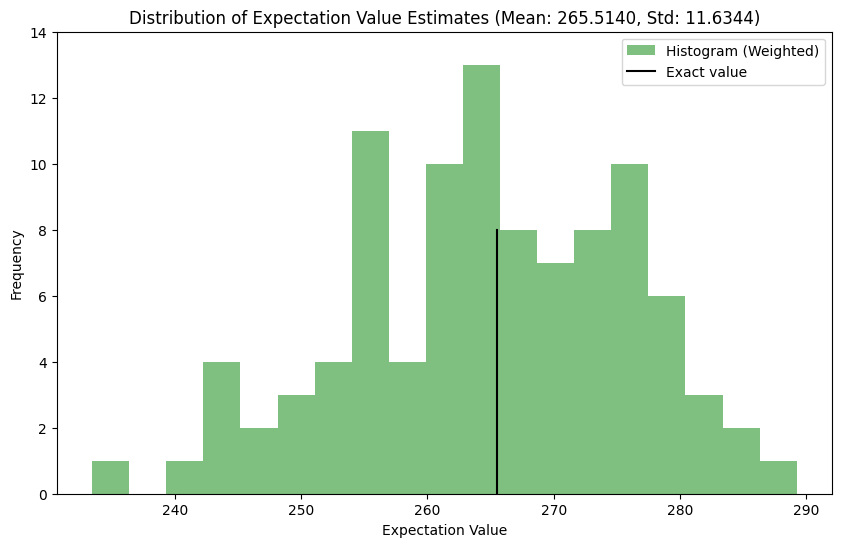

In [26]:
# Create a shorthand for our weighted estimator
def weighted_estimator(total_shots):
    return compute_shot_expectation_value_v2(weighted_program_set, circuit_allocation, total_shots)

# Run the trials and plot the results
weighted_ev = gather_and_plot_statistics(weighted_estimator, exact_expectation_value, total_shots, num_trials,
                                         color="green", label="Histogram (Weighted)")

## 5. Comparison of uniform and weighted shot allocation
Now let's compare the results of the uniform and weighted shot allocation strategies by plotting the above histograms side by side.

Uniform allocation - Mean: 265.6487, Std: 22.1004
Weighted allocation - Mean: 265.5140, Std: 11.6344
Variance reduction: 72.29%


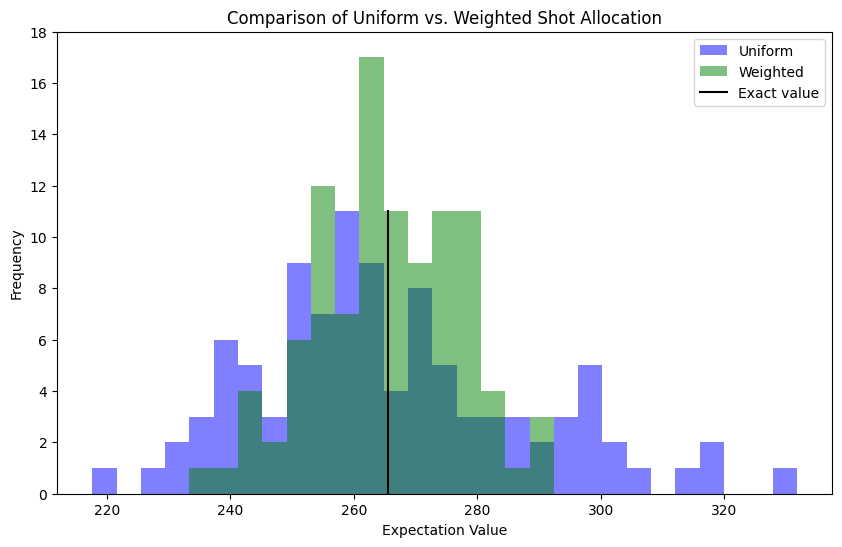

In [27]:
plt.figure(figsize=(10, 6))

# Plot histograms for both methods
bins = np.linspace(
    min(np.min(uniform_ev), np.min(weighted_ev)),
    max(np.max(uniform_ev), np.max(weighted_ev)),
    30
)
plt.hist(uniform_ev, alpha=0.5, bins=bins, label="Uniform", color="blue")
plt.hist(weighted_ev, alpha=0.5, bins=bins, label="Weighted", color="green")

# Set the y-axis limit
y_max = int(np.ceil(plt.ylim()[1]))
plt.ylim(0, y_max)

# Plot reference lines
ev_line_height = (2*y_max//3)
plt.plot([exact_expectation_value]*ev_line_height, np.arange(ev_line_height), color="black", label="Exact value")

# Add labels and legend
plt.xlabel("Expectation Value")
plt.ylabel("Frequency")
plt.title("Comparison of Uniform vs. Weighted Shot Allocation")
plt.legend()

# Print statistics
uniform_mean = np.mean(uniform_ev)
uniform_std = np.std(uniform_ev)
weighted_mean = np.mean(weighted_ev)
weighted_std = np.std(weighted_ev)

print(f"Uniform allocation - Mean: {uniform_mean:.4f}, Std: {uniform_std:.4f}")
print(f"Weighted allocation - Mean: {weighted_mean:.4f}, Std: {weighted_std:.4f}")
print(f"Variance reduction: {(uniform_std**2 - weighted_std**2) / uniform_std**2 * 100:.2f}%")

The results demonstrate the power of intelligent shot allocation. By strategically distributing our shot budget based on coefficient magnitudes rather than uniformly across all terms, we achieved a substantial variance reduction!

To verify that this improvement is not specific to our particular choice of Hamiltonian and quantum state, we conducted a broader statistical study. We repeated the entire experiment 100 times with different random Hamiltonians and states (you can experiment with that by removing the random seed and rerunning the notebook). The figure below summarizes the results:
![Figure showing plots of standard deviation and variance reduction of weighted against uniform shot-allocation approach. It can be seen that the mean variance reduction (across 100 runs) is more than 70%](images/weighted_vs_uniform_statistics.png)

The results confirm that weighted shot allocation consistently outperforms uniform allocation, with an average variance reduction exceeding 70% across (somewhat) diverse problem instances.

## 6. Conclusion
This notebook explored the challenge of shot allocation in quantum expectation value calculations and how to approach it using Braket's `ProgramSet` feature.

### 6.1 Key takeaways

1. **New `ProgramSet` Feature**: Braket's `ProgramSet` feature enables batch submission of multiple quantum circuits. This can simplify the implementation of expectation value calculations, as we can provide a (`Sum`) Hamiltonian as the only observable when creating the `ProgramSet` and let Braket handle the operator averaging internally.

2. **Uniform Allocation Limitations**: The default uniform shot allocation strategy, while simple to implement, can be highly inefficient for Hamiltonians with terms of varying magnitudes. We showed how this approach results in high variance in the estimated expectation values due to equal resource allocation regardless of coefficient importance.

3. **Weighted Allocation Implementation and Benefits**: We showed how to implement a weighted shot allocation strategy that distributes shots proportional to coefficient magnitudes. With it we achieved substantial variance reduction in expectation value estimates with consistent performance across diverse problem instances (>70% average improvement)

4. **Practical Trade-offs**: The weighted approach requires more circuits (100 vs. 10 in our example) but maintains the same total shot budget and cost, resulting in the trading of longer execution time for increased accuracy. It is important to note that this trade-off is for a single expectation value calculation only, and in more complex iterative workflows (like VQE) the better accuracy per iteration may actually result in a shorter total runtime for the algorithm (due to, e.g., faster convergence). 
